In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import joblib

import os 
os.chdir('..')
print(f'Current Directory: {os.getcwd()}')

import logging
logging.basicConfig(
    level=logging.INFO
)
logger = logging.getLogger(__name__)

Current Directory: C:\Users\user\Desktop\Masters\ISYE-6740 Computational Data Analytics\project\Anomaly-Detection-in-Industrial-Inspection


In [155]:
from utility_functions.utility_functions import (
    load_data,
    reshape_images,
    plot_class_distribution_grid,
    _report_metrics,
    _report_metrics_per_class_instance,
    _report_metrics_subset,
    _filter_to_subset,
    plot_confusion_matrix,
    plot_confusion_matrix_simple,
    load_model_and_predict
)
from data.target_mappings import TargetMappings

DATA_PATH = './data/project_data.mat'
N_INIT = 7
RAND_SEED = 123
DEFECTIVE = [i for i in range(0, 29, 2)]
NON_DEFECTIVE = [i for i in range(1, 29, 2)]

In [6]:
def report_all_metrics(y_test, y_train, y_pred, X_test, classifier, model_name, to_pd, to_display=True):
    overall_performance = _report_metrics(y_test=y_test, y_train=y_train, preds=y_pred, model_name=model_name)
    result_per_class = _report_metrics_per_class_instance(y_test=y_test, 
                                   y_train=y_train, 
                                   X_test=x_test, 
                                   classifier=classifier, 
                                   model_name=model_name, 
                                   to_pd=to_pd)

    if to_display:
        display('Overall Performance on the test set')
        display(overall_performance)
        display('Results of Defective Classes')
        display(result_per_class[result_per_class.Class.isin(DEFECTIVE)].sort_values('F1 Score', ascending=False))
        
        display('Results of Non-Defective Classes')
        display(result_per_class[result_per_class.Class.isin(NON_DEFECTIVE)].sort_values('F1 Score', ascending=False))
        
    return overall_performance, result_per_class

In [94]:
def train_predict_pipe(X_train: np.array, y_train: np.array, X_test: np.array, model: object, logger: logging.Logger = logger):
    """Trains a model then predict using test data."""
    logger.info(f' Fitting {type(model).__name__} with {len(X_train)} samples')
    model.fit(X_train, y_train)
    
    logger.info(f' Predicting {type(model).__name__} with {len(X_test)} samples')
    preds = model.predict(X_test)
    return model, preds

# EDA

In [11]:
data, x_train, x_test, y_train, y_test = load_data(DATA_PATH)
target_mappings = TargetMappings.MAPPING_DICT.value

INFO:utility_functions.utility_functions:Sample Size: 5354 | Train size: 4283 (0.800) | Test size: 1071 (0.200)
INFO:utility_functions.utility_functions:Image Dimension: (5354, 128, 128, 3)


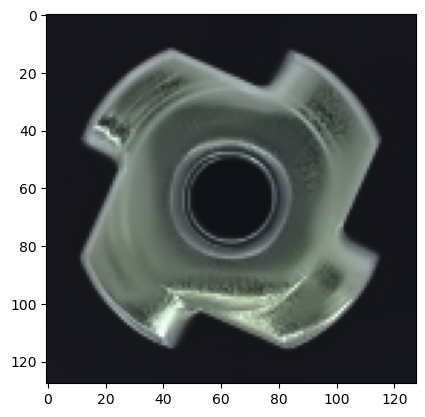

In [8]:
plt.imshow(x_train[0])

In [9]:
y_train[0]

15

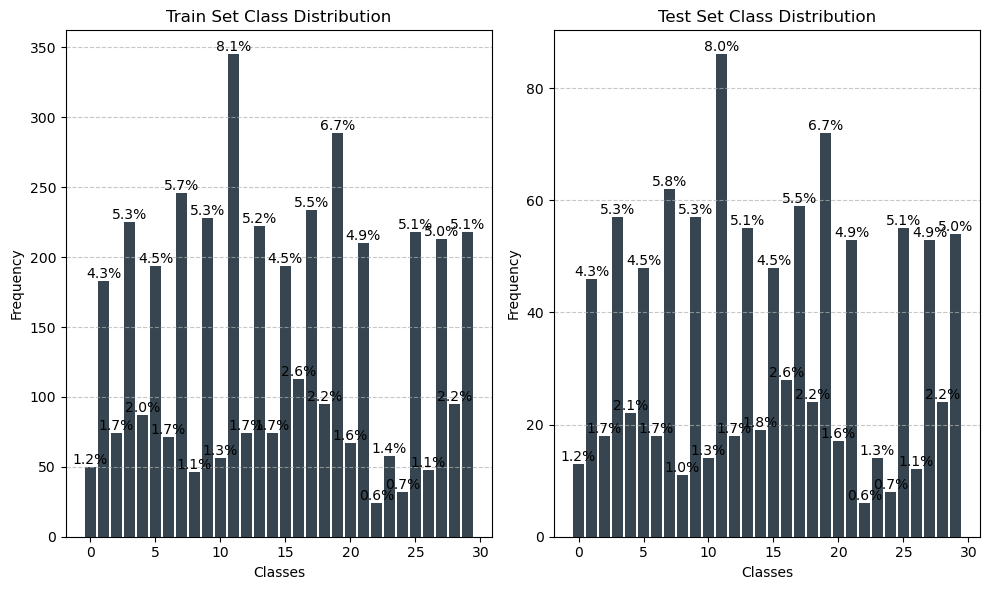

In [55]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
plot_class_distribution_grid(y_train, ax[0], 'Train Set Class Distribution')
plot_class_distribution_grid(y_test, ax[1], 'Test Set Class Distribution')
plt.tight_layout()
plt.show()

In [13]:
x_train_reshaped = reshape_images(x_train)
x_test_reshaped = reshape_images(x_test)

Original dimensions: (4283, 128, 128, 3)
Reshaped dimensions: (4283, 49152)
Original dimensions: (1071, 128, 128, 3)
Reshaped dimensions: (1071, 49152)


# Model Exploration

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import (
    SVC,
    LinearSVC
)

models = {
    "SVM": SVC(kernel='linear'),
    "Kernel SVM": SVC(kernel='rbf'),
}

## Models Fitting

In [17]:
results = []
defective_results = []
non_defective_results = [] 
for model_name, model in models.items():
    model_, preds = train_predict_pipe(x_train_reshaped, y_train, x_test_reshaped, model)
    
    results.append(_report_metrics(y_test, y_train, preds, model_name))
    defective_results.append(_report_metrics_subset(y_test, y_train, preds, model_name, DEFECTIVE))
    non_defective_results.append(_report_metrics_subset(y_test, y_train, preds, model_name, NON_DEFECTIVE))
                                 
model_results = pd.concat(results, ignore_index=True)
defective_results = pd.concat(defective_results, ignore_index=True)
non_defective_results = pd.concat(non_defective_results, ignore_index=True)

INFO:__main__: Fitting SVC with 4283 samples
INFO:__main__: Predicting SVC with 1071 samples
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

## Models Performances

In [21]:
model_results.sort_values('F1 Score', ascending=False)

,Model,Train Size,Test Size,Accuracy,F1 Score,Precision,Recall
0,SVM,4283,1071,0.816993,0.686944,0.749745,0.674883
1,Kernel SVM,4283,1071,0.764706,0.448002,0.480783,0.507056


### Performance on Defective Samples

In [23]:
defective_results.sort_values('F1 Score', ascending=False)

,Model,Train Size,Test Size,Accuracy,F1 Score,Precision,Recall
0,SVM,4283,252,0.440476,0.272804,0.466667,0.205944
1,Kernel SVM,4283,252,0.015873,0.017265,0.100000,0.009527


### Performance on Non-Defective Samples

In [25]:
non_defective_results.sort_values('F1 Score', ascending=False)

,Model,Train Size,Test Size,Accuracy,F1 Score,Precision,Recall
1,Kernel SVM,4283,765,0.994771,0.994790,0.994967,0.994704
0,SVM,4283,765,0.929412,0.518578,0.535458,0.503335


In [27]:
combined = np.array(list(zip(y_test, preds)))
combined

array([[27, 27],
       [ 7,  7],
       [10, 11],
       ...,
       [27, 27],
       [15, 15],
       [29, 29]])

# SVM Initial Fitting

In [46]:
svm_model = models['SVM']

In [140]:
performance, class_performance = report_all_metrics(y_test, y_train, y_pred, x_test_reshaped, svm_model, 'Linear SVC', True, True)

'Overall Performance on the test set'

,Model,Train Size,Test Size,Accuracy,F1 Score,Precision,Recall
0,Linear SVC,4283,1071,0.816993,0.686944,0.749745,0.674883


'Results of Defective Classes'

,Class,Model,Train Size,Test Size,Accuracy,F1 Score,Precision,Recall
0,0,Linear SVC,4283,13,0.307692,0.307692,0.307692,0.307692
2,2,Linear SVC,4283,18,0.444444,0.444444,0.444444,0.444444
4,4,Linear SVC,4283,22,0.909091,0.909091,0.909091,0.909091
6,6,Linear SVC,4283,18,0.000000,0.000000,0.000000,0.000000
8,8,Linear SVC,4283,11,0.090909,0.090909,0.090909,0.090909
10,10,Linear SVC,4283,14,0.285714,0.285714,0.285714,0.285714
12,12,Linear SVC,4283,18,0.833333,0.833333,0.833333,0.833333
14,14,Linear SVC,4283,19,0.526316,0.526316,0.526316,0.526316
16,16,Linear SVC,4283,28,0.535714,0.535714,0.535714,0.535714
18,18,Linear SVC,4283,24,0.416667,0.416667,0.416667,0.416667


'Results of Non-Defective Classes'

,Class,Model,Train Size,Test Size,Accuracy,F1 Score,Precision,Recall
1,1,Linear SVC,4283,46,1.000000,1.000000,1.000000,1.000000
3,3,Linear SVC,4283,57,0.929825,0.929825,0.929825,0.929825
5,5,Linear SVC,4283,48,0.937500,0.937500,0.937500,0.937500
7,7,Linear SVC,4283,62,0.951613,0.951613,0.951613,0.951613
9,9,Linear SVC,4283,57,0.859649,0.859649,0.859649,0.859649
11,11,Linear SVC,4283,86,0.941860,0.941860,0.941860,0.941860
13,13,Linear SVC,4283,55,0.909091,0.909091,0.909091,0.909091
15,15,Linear SVC,4283,48,0.958333,0.958333,0.958333,0.958333
17,17,Linear SVC,4283,59,0.813559,0.813559,0.813559,0.813559
19,19,Linear SVC,4283,72,0.916667,0.916667,0.916667,0.916667


# PCA

In [41]:
from sklearn.decomposition import PCA
pca = PCA(
    n_components=N_INIT,
    random_state=RAND_SEED
)
x_train_transformed = pca.fit_transform(x_train_reshaped)
x_test_transformed = pca.fit_transform(x_test_reshaped)

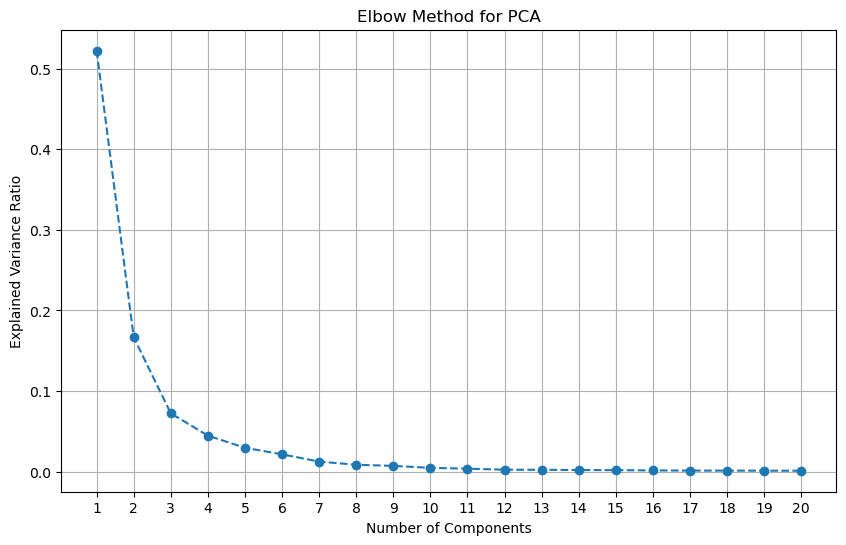

In [56]:
pca = PCA(
    n_components=20,
    random_state=RAND_SEED
)
pca = pca.fit(x_train_reshaped)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Elbow Method for PCA')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()

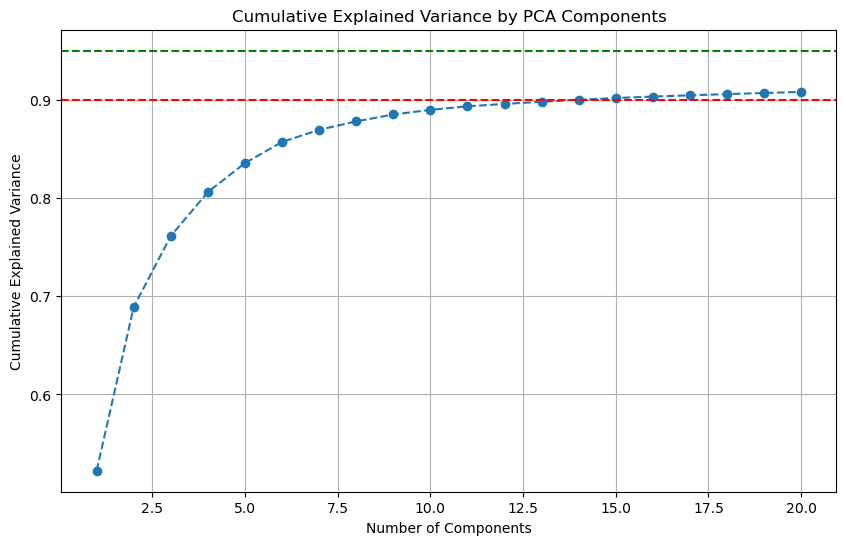

In [58]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='--') 
plt.axhline(y=0.95, color='g', linestyle='--') 
plt.grid()
plt.show()

In [66]:
pca = PCA(
    n_components=13,
    random_state=RAND_SEED
)
x_train_transformed = pca.fit_transform(x_train_reshaped)
x_test_transformed = pca.fit_transform(x_test_reshaped)

## PCA Transformed Results

In [103]:
svm_model, preds = train_predict_pipe(x_train_transformed, y_train, x_test_transformed, svm_model)
_report_metrics_subset(y_test, y_train, preds, 'Linear SVC', DEFECTIVE)

INFO:__main__: Fitting SVC with 4283 samples
INFO:__main__: Predicting SVC with 1071 samples
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Train Size,Test Size,Accuracy,F1 Score,Precision,Recall
0,Linear SVC,4283,252,0.416667,0.273283,0.392857,0.229216


C:\Users\user\AppData\Local\Temp\ipykernel_4484\2489499965.py:18: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


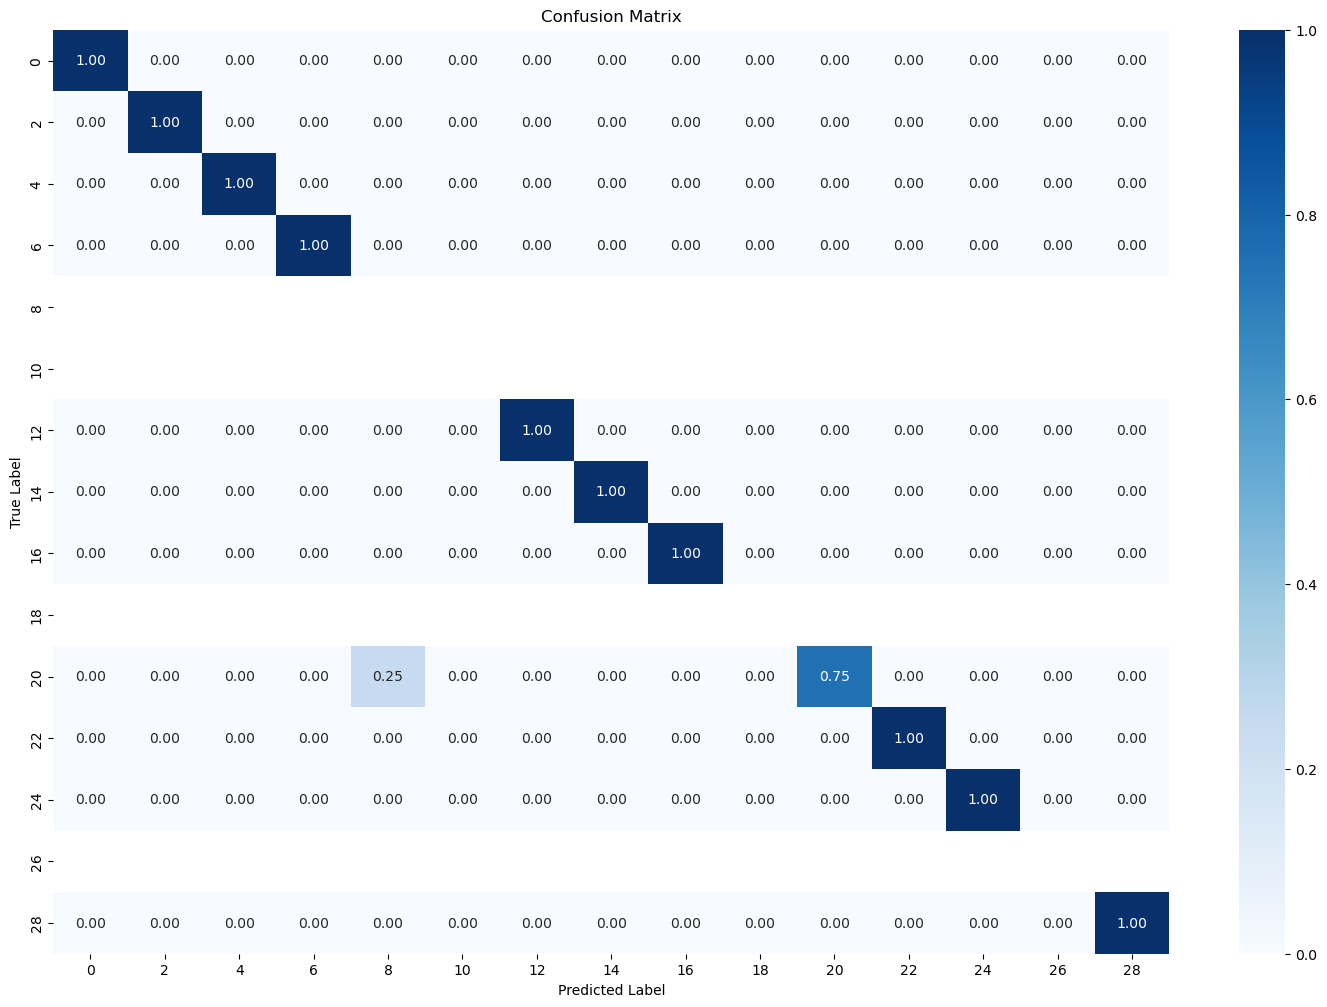

In [151]:
y_test_defect, preds_defect = _filter_to_subset(y_test, preds, DEFECTIVE)
plot_confusion_matrix_simple(y_test_defect, preds_defect, DEFECTIVE)

> Model fitting becomes very fast after PCA. 

## Original Data

In [74]:
svm_model, preds = train_predict_pipe(x_train_reshaped, y_train, x_test_reshaped, svm_model)
_report_metrics_subset(y_test, y_train, preds, 'Linear SVC', DEFECTIVE)

INFO:__main__: Fitting SVC with 4283 samples
INFO:__main__: Predicting SVC with 1071 samples
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Train Size,Test Size,Accuracy,F1 Score,Precision,Recall
0,Linear SVC,4283,252,0.440476,0.272804,0.466667,0.205944


In [157]:
svm_model, preds = load_model_and_predict('./supervised_learning_stage/ex_1_pca_and_svm/vanila_svm_model.pkl', x_test_reshaped)

C:\Users\user\Desktop\Masters\ISYE-6740 Computational Data Analytics\project\Anomaly-Detection-in-Industrial-Inspection\utility_functions\utility_functions.py:315: RuntimeWarning: invalid value encountered in divide


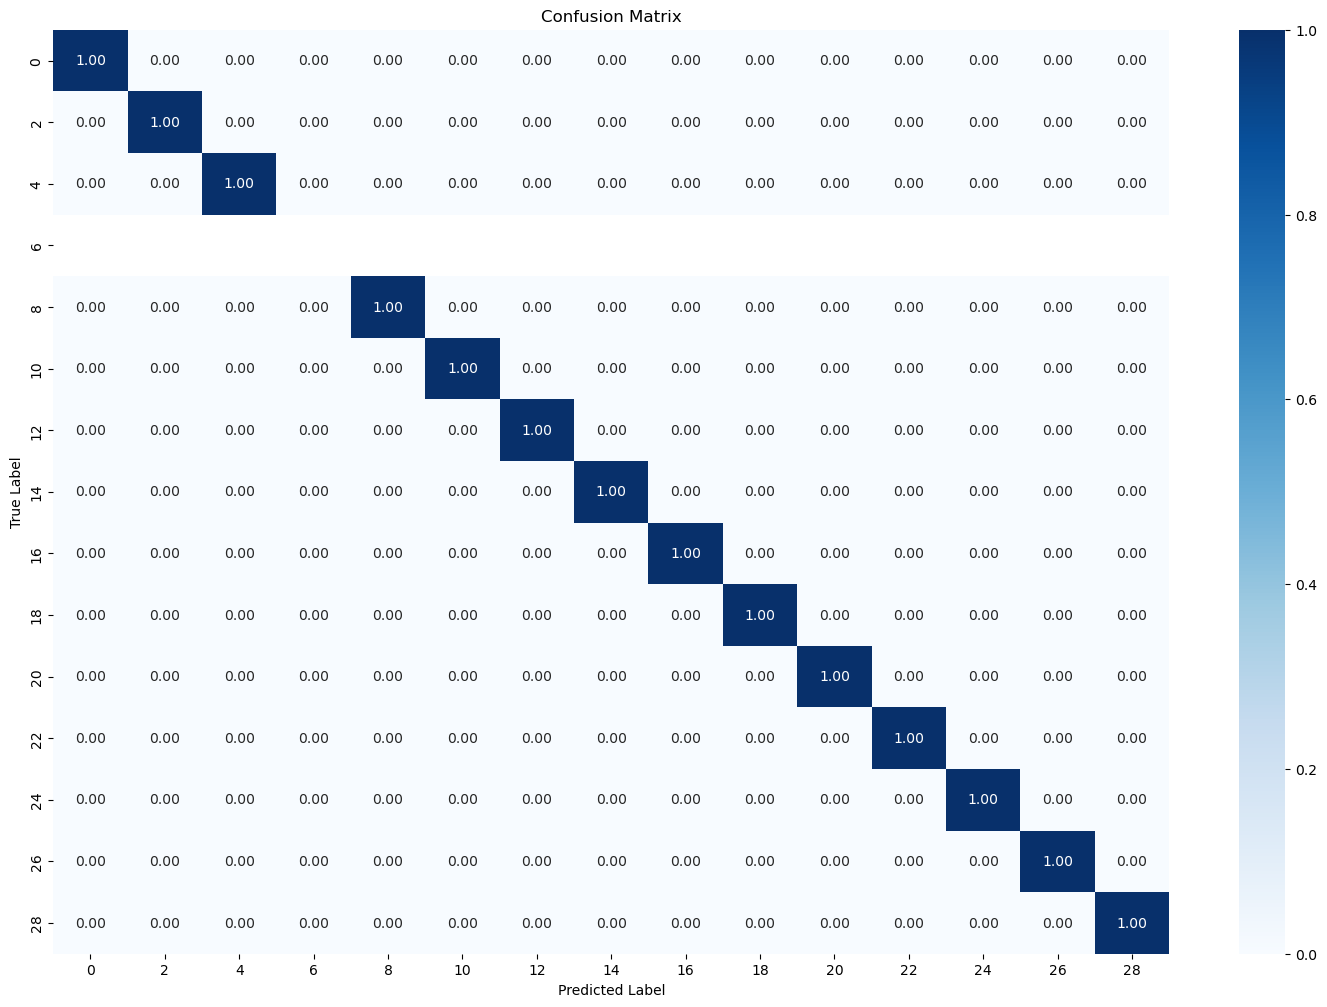

In [158]:
y_test_defect, preds_defect = _filter_to_subset(y_test, preds, DEFECTIVE)
plot_confusion_matrix_simple(y_test_defect, preds_defect, DEFECTIVE)

In [ ]:
# list(zip(y_test_defect, preds_defect))

> There is a great reduction in precision and a slight decrease on all metrics. But the run time is much more faster with PCA.

### Grid Search Trial

In [ ]:
## PCA Transformed

In [173]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
}
model = models['SVM']
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train_transformed, y_train)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Best Parameters: {'C': 10, 'gamma': 0.01}
Best Cross-Validation Score: 0.8087833564161006


In [ ]:
## Original Data

In [ ]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train_reshaped, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)